In [33]:
import numpy as np
import os
import csv
import random

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

### initial

In [34]:
# set manual seed for reproducibility
seed = 33

# general reproducibility
random.seed(seed)
np.random.seed(seed)

#constant
num_lable_kinds = 5
both_cols = 6
high_rows = 60
short_rows = 50

output_dim = 5

In [35]:
#numpy to store data
high_data = np.empty((0, high_rows, both_cols), dtype=float)
high_label = np.empty((0, num_lable_kinds), dtype=int)
short_data = np.empty((0, short_rows, both_cols), dtype=float)
short_label = np.empty((0, num_lable_kinds), dtype=int)

# predefine

## function of preprocess

### function of finding a hit

In [36]:
def slope(input_data):
    slope_col = np.zeros(len(input_data),dtype=float)
    for i in range(len(input_data) - 1):
        for j in range(1,4):
            temp = input_data[i+1][j] - input_data[i][j]
            slope_col[i] += temp**2
        slope_col[i] = slope_col[i]**0.5
    return slope_col

def ma(slope_col, n):
    slope_ma = np.zeros(len(slope_col),dtype=float)
    for i in range(n,len(slope_col)-n):
        for j in range(-n,n+1):
            slope_ma[i] += slope_col[i+j]
        slope_ma[i] /= float(2*n+1)
    return slope_ma

def data_cut(input_data, save_data, hit_type):
    slope_col = slope(input_data)
    slope_avg = np.average(slope_col)
    # n = 4
    if hit_type == "high":
        n = 6
    elif hit_type == "short":
        n = 5
    slope_ma = ma(slope_col, n)

    for i in range(60,len(slope_col)-50):

        if ( slope_ma[i] > slope_avg ) and ( slope_col[i]==max(slope_col[i-50:i+50]) ) : # 找到可能峰值
            start = 0  # 向前&向後找起點
            end = 0
            while i+start > (50+n) :
                start -= 1
                if slope_ma[i+start] <= slope_avg:
                    break
            while i+end < (len(slope_col)-50-n) :
                end += 1
                if slope_ma[i+end] <= slope_avg:
                    break

            if  hit_type == "high" and end-start > 40 and slope_ma[i] > 15: # 長遠球
                save_data.append(input_data[i-45:i+15, [1,2,3,5,6,7]])

            elif hit_type == "short" and end-start > 20 and slope_ma[i] > 15: # 挑球
                save_data.append(input_data[i-35:i+15, [1,2,3,5,6,7]])

### other function

In [37]:
# Removes null bytes from the input file and returns a sanitized version of the file.
def sanitize_file(input_file_path):
    sanitized_content = ""
    with open(input_file_path, 'r', encoding='utf-8', errors='replace') as f:
        content = f.read()
        sanitized_content = content.replace('\x00', '')

    return sanitized_content

In [38]:
def hit_preprocess(input_file_path, hit_type):

  # Sanitize the file by removing null bytes
  sanitized_content = sanitize_file(input_file_path)
  lines = sanitized_content.split('\n')

  # Starting from the last line, move upwards until a complete line (with 7 commas) is found
  while lines and lines[-1].count(",") != 7:
    lines = lines[:-1]

  # Load the (potentially modified) data into a numpy array
  input_data = np.loadtxt(lines, delimiter=",", dtype=float)

  cut_data = []
  data_cut(input_data, cut_data, hit_type)
  cut_data = np.array(cut_data).astype(float)

  datas_label = np.empty((0, num_lable_kinds), dtype=int)
  label_values = np.array([int(ch) for ch in input_filename[6:11]])  # 轉換為整數陣列
  label_values = label_values[np.newaxis, :]  # 增加一個維度以使其成為二維陣列
  for i in range(len(cut_data)):
    datas_label = np.vstack((datas_label, label_values))

  return cut_data,datas_label

## preprocess

In [39]:
# 指定資料集所在的路徑
data_path = "/content/"
# 取得該路徑下所有的檔案名稱
all_files = os.listdir(data_path)
# 過濾出所有的 .txt 檔案
txt_files = [file_name for file_name in all_files if file_name.endswith('.txt')]

for input_filename in txt_files:

  if "high" in input_filename.lower():
    hit_type = "high"
  elif "short" in input_filename.lower():
    hit_type = "short"
  else:
    print("error txt-file")
    continue

  input_file_path = os.path.join(data_path, input_filename)
  data, label = hit_preprocess(input_file_path, hit_type)

  if hit_type == "high":
    high_data = np.concatenate((high_data, data), axis=0)
    high_label = np.concatenate((high_label, label))
  elif hit_type == "short":
    short_data = np.concatenate((short_data, data), axis=0)
    short_label = np.concatenate((short_label, label))

  os.remove(input_file_path)

## function to reorder and split

### shuffle, shuffle_direct

In [40]:
#input:data and label, output:numpy with same shape, but shuffled
#process: shuffle (data,label)
def shuffle(datas,labels):
  if len(datas) != len(labels):
    print("error")
    return


  shuffled_datas = []
  shuffled_labels = []

  # Shuffle the data indices
  indices = np.arange(len(datas))
  np.random.shuffle(indices)

  for i in range(len(datas)):
    shuffled_datas.append(datas[indices[i]])
    shuffled_labels.append(labels[indices[i]])

  return np.array(shuffled_datas), np.array(shuffled_labels)

In [41]:
#direct change input's data and label
def shuffle_direct(datas,labels):
  if len(datas) != len(labels):
    print("error")
    return


  shuffled_datas_list = []
  shuffled_labels_list = []

  # Shuffle the data indices
  indices = np.arange(len(datas))
  np.random.shuffle(indices)

  for i in range(len(datas)):
    shuffled_datas_list.append(datas[indices[i]])
    shuffled_labels_list.append(labels[indices[i]])

  shuffled_datas = np.array(shuffled_datas_list)
  shuffled_labels = np.array(shuffled_labels_list)

  datas[:] = shuffled_datas
  labels[:] = shuffled_labels

### sort, sort_direct

In [42]:
#input:data and label, output:numpy with same shape, but sorted
#process: sort (data,label)
def sort(datas,labels):
  if len(datas) != len(labels):
    print("error")
    return

  label_sums = labels.sum(axis=1)
  sorted_indice = np.argsort(label_sums,kind='stable')

  sorted_datas = []
  sorted_labels = []

  for i in range(len(datas)):
    sorted_datas.append(datas[sorted_indice[i]])
    sorted_labels.append(labels[sorted_indice[i]])

  return np.array(sorted_datas), np.array(sorted_labels)

In [43]:
#direct change input's data and label
def sort_direct(datas,labels):
  if len(datas) != len(labels):
    print("error")
    return

  label_sums = labels.sum(axis=1)
  sorted_indice = np.argsort(label_sums,kind='stable')

  sorted_datas_list = []
  sorted_labels_list = []

  for i in range(len(datas)):
    sorted_datas_list.append(datas[sorted_indice[i]])
    sorted_labels_list.append(labels[sorted_indice[i]])

  sorted_datas = np.array(sorted_datas_list)
  sorted_labels = np.array(sorted_labels_list)

  datas[:] = sorted_datas
  labels[:] = sorted_labels

### split_percentage, split_equal_to_n

In [44]:
#input: data, label and percentage of test
#output: numpy, (train_data, train_label, test_data, test_label)
def split_percentage(datas,labels,test_percent):
  num_train = round(len(datas) * (1 - test_percent))

  train_data = datas[:num_train]
  train_label = labels[:num_train]
  test_data = datas[num_train:]
  test_label = labels[num_train:]
  return train_data, train_label, test_data, test_label

In [45]:
#input: data, label and number of client
#output: numpy, [ data1 data2 ...], data1 = output[0]
def split_equal_to_n(datas,labels,n_Clients):
  num_items_per_client = len(datas) // n_Clients
  client_data = []
  client_label = []

  for i in range(n_Clients):
    start_idx = i * num_items_per_client
    end_idx = (i + 1) * num_items_per_client
    client_data.append(datas[start_idx:end_idx])
    client_label.append(labels[start_idx:end_idx])

  return np.array(client_data), np.array(client_label)

## function to average weight and split score

### average_weight

In [46]:
def average_weight(models):
  #avg
  avg_weights = list()
  nummodel = len(models)
  for i,model in enumerate(models):
    weights = model.get_weights()

    for j in range(len(weights)):
      if i==0:
        avg_weights.append(weights[j])
      else:
        avg_weights[j]=avg_weights[j]+weights[j]

  for i in range(len(weights)):
    avg_weights[i]=avg_weights[i] / nummodel

  # set
  for i,model in enumerate(models):
    weights = model.get_weights()

    for j in range(len(weights)):
      weights[j] = avg_weights[j]

    model.set_weights(weights)

### split_label_score

In [47]:
def split_label_score(datas,labels):
  if len(datas) != len(labels):
    print("error")
    return

  client_data = []
  client_label = []

  stdt, stlb = sort(datas,labels)
  means = np.mean(stlb, axis=1)
  rounded_means = np.round(means)

  start_idx = 0
  end_idx = 0
  temp_label = 1

  for i in range(len(stlb)):
    if rounded_means[i] != temp_label:
      end_idx = i
      client_data.append(stdt[start_idx:end_idx])
      client_label.append(stlb[start_idx:end_idx])
      start_idx = i
      temp_label = temp_label + 1
  end_idx = len(stlb)
  client_data.append(stdt[start_idx:end_idx])
  client_label.append(stlb[start_idx:end_idx])

  while temp_label < num_lable_kinds :
    client_data.append(stdt[end_idx:end_idx])
    client_label.append(stlb[end_idx:end_idx])
    temp_label=temp_label+1

  return np.array(client_data, dtype=object), np.array(client_label, dtype=object)

In [48]:
def noniid_split(datas,labels):
  if len(datas) != len(labels):
    print("error")
    return

  stdt, stlb = sort(datas,labels)
  means = np.mean(stlb, axis=1)
  rounded_means = np.round(means)

  start_idx = 0
  end_idx = 0

  for i in range(len(stlb)):
    if rounded_means[i] == 3:
      end_idx = i
      data12 = stdt[start_idx:end_idx]
      label12 = stlb[start_idx:end_idx]
      start_idx = i
      break

  end_idx = len(stlb)
  data345 = stdt[start_idx:end_idx]
  label345 = stlb[start_idx:end_idx]

  shuffle_direct(data12,label12)
  shuffle_direct(data345,label345)

  data12_08, label12_08, data12_02, label12_02 = split_percentage(data12,label12,0.2)
  data345_08, label345_08, data345_02, label345_02 = split_percentage(data345,label345,0.2)

  dataone = np.concatenate((data12_08, data345_02), axis=0)
  labelone = np.concatenate((label12_08,label345_02), axis=0)

  datatwo = np.concatenate((data345_08,data12_02), axis=0)
  labeltwo = np.concatenate((label345_08,label12_02), axis=0)

  shuffle_direct(dataone,labelone)
  shuffle_direct(datatwo,labeltwo)

  return dataone, labelone, datatwo, labeltwo

## plot

In [49]:
def plot(num_ep,dt_train,dt_val,title):
  epochs = range(1,num_ep+1)
  plt.plot(epochs, dt_train, 'g', label='train')
  plt.plot(epochs, dt_val, 'b', label='validation')
  plt.title(title)
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()
  print("Epoch",num_ep,": ",dt_val[num_ep-1])

In [50]:
def plot_batch(num_ep,historys,key,title):
  colors = ['b','g','r','c','m','y']
  epochs = range(1,Epoch+1)
  for i in range(len(historys)):
    plt.plot(epochs, historys[i].history[key], colors[i%6], label='Batch:'+str(Bs[i]))
  plt.title(title)
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()

# models

### output,loss,accuracy,CNNpreprocess

In [51]:
# Define custom output function
def custom_output(x):
  # Implement your custom output logic here
  return x

def cus_loss(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)  # Cast y_true to float32
  loss = tf.reduce_mean(tf.square(y_true - y_pred))
  return loss

# Define custom accuracy function
threshold = 0.5
def cus_acc(y_true, y_pred):
  abs_diff = tf.abs(y_true - y_pred)
  condition = tf.less_equal(abs_diff, threshold)
  acc = tf.cast(condition, tf.float32)
  return acc

# 為了適應CNN的輸入要求，在數據集加載過程中添加一個維度
def CNNpreprocess(data):
  # 增加一個維度以模擬“通道”
  return tf.expand_dims(data, -1)

### LSTM_mymodel

In [52]:
class LSTM_mymodel(Model):
  def __init__(self, units, output_dim, num_layers, dropout_rate):
    super(LSTM_mymodel, self).__init__()
    self.lstm_layers = [LSTM(units, return_sequences=(i < num_layers - 1)) for i in range(num_layers)]
    self.dropout = Dropout(rate=dropout_rate)
    self.dense = Dense(output_dim)

  def call(self, inputs):
    x = inputs
    for lstm_layer in self.lstm_layers:
      x = lstm_layer(x)
      x = self.dropout(x)  # Apply dropout after each LSTM layer
    output = self.dense(x)
    output = custom_output(output)
    return output

### GRU_mymodel

In [53]:
class GRU_mymodel(Model):
  def __init__(self, units, output_dim, num_layers, dropout_rate):
    super(GRU_mymodel, self).__init__()
    self.gru_layers = [GRU(units, return_sequences=(i < num_layers - 1)) for i in range(num_layers)]
    self.dropout = Dropout(rate=dropout_rate)
    self.dense = Dense(output_dim)

  def call(self, inputs):
    x = inputs
    for gru_layer in self.gru_layers:
      x = gru_layer(x)
      x = self.dropout(x)  # Apply dropout after each GRU layer
    output = self.dense(x)
    output = custom_output(output)
    return output

### CNN_mymodel

In [54]:
# CNN
class CNN_mymodel(Model):
  def __init__(self, output_dim, num_filters, kernel_size, dropout_rate):
    super(CNN_mymodel, self).__init__()
    self.conv1 = Conv2D(num_filters, kernel_size, activation='relu', padding='same')
    self.pool1 = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same')
    self.conv2 = Conv2D(num_filters, kernel_size, activation='relu', padding='same')
    self.pool2 = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same')
    self.flatten = Flatten()
    self.dropout = Dropout(rate=dropout_rate)
    self.dense = Dense(output_dim)

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool2(x)
    x = self.flatten(x)
    x = self.dropout(x)
    output = self.dense(x)
    output = custom_output(output)
    return output

# main

In [55]:
test_percent = 0.1

Units=64
Output_Dim = 5
Num_Layers = 1
Dropout_Rate = 0
Num_Filters = 64
Kernel_Size = (7, 7)

#learning_rate
LSTM_lr = 0.01
GRU_lr = 0.01
CNN_lr = 0.0001

#learning_rate
LSTM_drop = 0
GRU_drop = 0
CNN_drop = 0.5

#learning_rate
# LSTM_bs = 16
# GRU_bs = 16
# CNN_bs = 20

#Epoch
Epoch = 50

#Batch_Size
Bs = [10,16,20,24,32,40]

# # constant for fedavg
# num_model = 3
# num_round = 2
# num_fit = 10
# # constant

## centralize

In [56]:
shuffle_direct(high_data, high_label)
train_data, train_label, test_data, test_label = split_percentage(high_data,high_label,test_percent)

### lstm

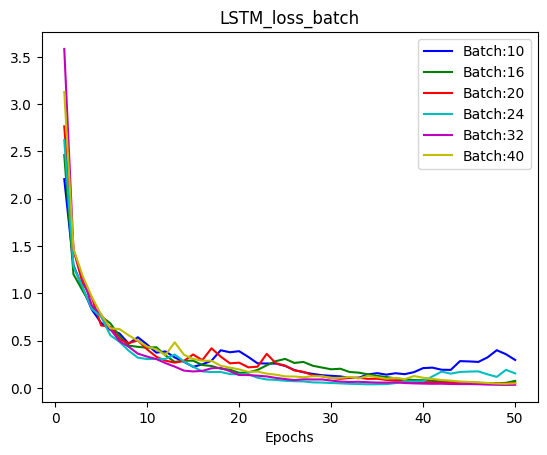

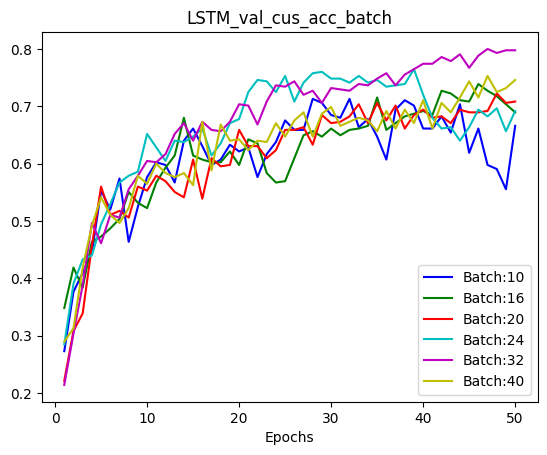

In [57]:
cen_LSTM_history = []

for i in range(len(Bs)):
  cen_LSTM = LSTM_mymodel(units=Units,output_dim=Output_Dim,num_layers=Num_Layers,dropout_rate=LSTM_drop)
  cen_LSTM.compile(optimizer=Adam(learning_rate=LSTM_lr),loss=cus_loss, metrics=[cus_acc])
  history = cen_LSTM.fit(train_data,train_label,epochs=Epoch,batch_size=Bs[i],verbose=0,
                                  validation_data=(test_data, test_label))
  cen_LSTM_history.append(history)

plot_batch(Epoch,cen_LSTM_history,'loss','LSTM_loss_batch')
plot_batch(Epoch,cen_LSTM_history,'val_cus_acc','LSTM_val_cus_acc_batch')


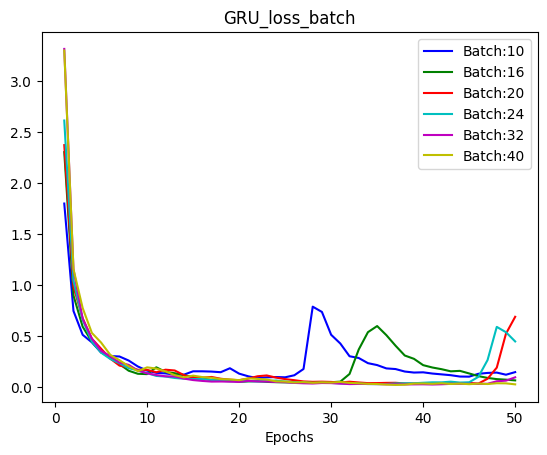

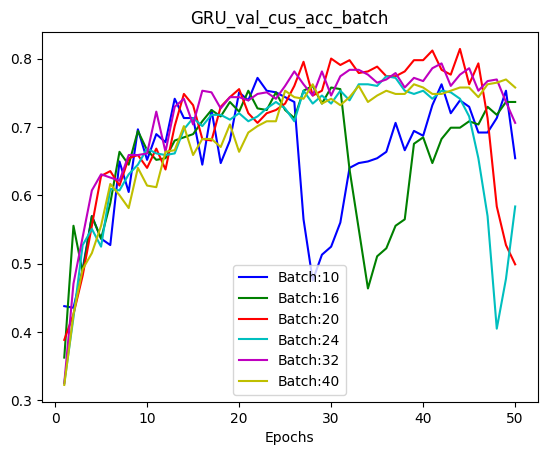

In [58]:
cen_GRU_history = []

for i in range(len(Bs)):
  cen_GRU = GRU_mymodel(units=Units,output_dim=Output_Dim,num_layers=Num_Layers,dropout_rate=GRU_drop)
  cen_GRU.compile(optimizer=Adam(learning_rate=GRU_lr),loss=cus_loss, metrics=[cus_acc])
  history = cen_GRU.fit(train_data,train_label,epochs=Epoch,batch_size=Bs[i],verbose=0,
                                  validation_data=(test_data, test_label))
  cen_GRU_history.append(history)

plot_batch(Epoch,cen_GRU_history,'loss','GRU_loss_batch')
plot_batch(Epoch,cen_GRU_history,'val_cus_acc','GRU_val_cus_acc_batch')

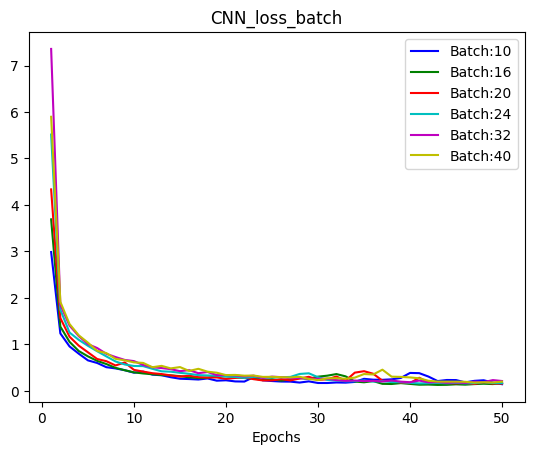

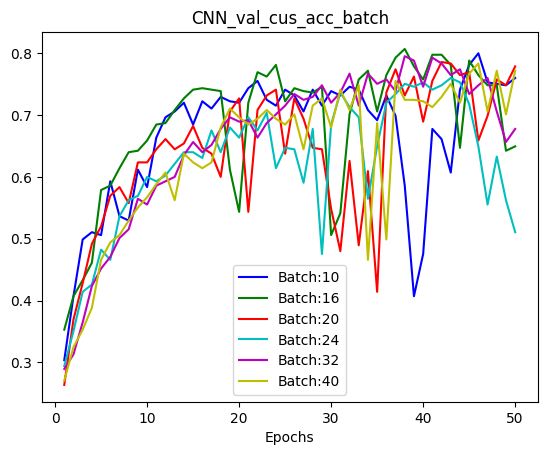

In [ ]:
train_tfdata = tf.data.Dataset.from_tensor_slices((train_data, train_label))
test_tfdata = tf.data.Dataset.from_tensor_slices((test_data, test_label))

train_tfdata = train_tfdata.map(lambda x, y: (CNNpreprocess(x), y))
test_tfdata = test_tfdata.map(lambda x, y: (CNNpreprocess(x), y))

cen_CNN_history = []

for i in range(len(Bs)):
  cen_CNN = CNN_mymodel(output_dim=Output_Dim, num_filters=Num_Filters, kernel_size=Kernel_Size, dropout_rate=CNN_drop)
  cen_CNN.compile(optimizer=Adam(learning_rate=CNN_lr),loss=cus_loss, metrics=[cus_acc])
  history = cen_CNN.fit(train_tfdata.batch(Bs[i]), epochs=Epoch,verbose=0, validation_data=test_tfdata.batch(Bs[i]))
  cen_CNN_history.append(history)

plot_batch(Epoch,cen_CNN_history,'loss','CNN_loss_batch')
plot_batch(Epoch,cen_CNN_history,'val_cus_acc','CNN_val_cus_acc_batch')

# end